# Customer Segmentation using Clustering
***
This mini-project is based on [this blog post](http://blog.yhat.com/posts/customer-segmentation-using-python.html) by yhat. Please feel free to refer to the post for additional information, and solutions.

In [61]:
%matplotlib inline
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

# Setup Seaborn
sns.set_style("whitegrid")
sns.set_context("poster")

## Data

The dataset contains information on marketing newsletters/e-mail campaigns (e-mail offers sent to customers) and transaction level data from customers. The transactional data shows which offer customers responded to, and what the customer ended up buying. The data is presented as an Excel workbook containing two worksheets. Each worksheet contains a different dataset.

In [2]:
df_offers = pd.read_excel("./WineKMC.xlsx", sheet_name=0)
df_offers.columns = ["offer_id", "campaign", "varietal", "min_qty", "discount", "origin", "past_peak"]
df_offers.head()

,offer_id,campaign,varietal,min_qty,discount,origin,past_peak
0,1,January,Malbec,72,56,France,False
1,2,January,Pinot Noir,72,17,France,False
2,3,February,Espumante,144,32,Oregon,True
3,4,February,Champagne,72,48,France,True
4,5,February,Cabernet Sauvignon,144,44,New Zealand,True


In [175]:
list(df_offers[df_offers.origin == 'California'].offer_id.values)

[10, 16, 21]

We see that the first dataset contains information about each offer such as the month it is in effect and several attributes about the wine that the offer refers to: the variety, minimum quantity, discount, country of origin and whether or not it is past peak. The second dataset in the second worksheet contains transactional data -- which offer each customer responded to.

In [3]:
df_transactions = pd.read_excel("./WineKMC.xlsx", sheet_name=1)
df_transactions.columns = ["customer_name", "offer_id"]
df_transactions['n'] = 1
df_transactions.head()

,customer_name,offer_id,n
0,Smith,2,1
1,Smith,24,1
2,Johnson,17,1
3,Johnson,24,1
4,Johnson,26,1


In [12]:
df_transactions.offer_id.sort_values().unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32],
      dtype=int64)

## Data wrangling

We're trying to learn more about how our customers behave, so we can use their behavior (whether or not they purchased something based on an offer) as a way to group similar minded customers together. We can then study those groups to look for patterns and trends which can help us formulate future offers.

The first thing we need is a way to compare customers. To do this, we're going to create a matrix that contains each customer and a 0/1 indicator for whether or not they responded to a given offer. 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set I</h3>

<p><b>Exercise:</b> Create a data frame where each row has the following columns (Use the pandas [`merge`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.merge.html) and [`pivot_table`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.pivot_table.html) functions for this purpose):
<ul>
<li> customer_name
<li> One column for each offer, with a 1 if the customer responded to the offer
</ul>
<p>Make sure you also deal with any weird values such as `NaN`. Read the documentation to develop your solution.</p>
</div>

In [5]:
#your turn
merged_df = df_transactions.merge(df_offers, how='left', on='offer_id')
merged_df.head()

,customer_name,offer_id,n,campaign,varietal,min_qty,discount,origin,past_peak
0,Smith,2,1,January,Pinot Noir,72,17,France,False
1,Smith,24,1,September,Pinot Noir,6,34,Italy,False
2,Johnson,17,1,July,Pinot Noir,12,47,Germany,False
3,Johnson,24,1,September,Pinot Noir,6,34,Italy,False
4,Johnson,26,1,October,Pinot Noir,144,83,Australia,False


In [16]:
pivoted_df = pd.pivot_table(merged_df, index='customer_name', columns='offer_id', values='n').fillna(0)
pivoted_df.head()

offer_id,1,2,3,4,5,6,7,8,9,10,...,23,24,25,26,27,28,29,30,31,32
customer_name,,,,,,,,,,,,,,,,,,,,,
Adams,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
Allen,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
Anderson,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
Bailey,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
Baker,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [17]:
pivoted_df.values

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 1.]])

## K-Means Clustering

Recall that in K-Means Clustering we want to *maximize* the distance between centroids and *minimize* the distance between data points and the respective centroid for the cluster they are in. True evaluation for unsupervised learning would require labeled data; however, we can use a variety of intuitive metrics to try to pick the number of clusters K. We will introduce two methods: the Elbow method, the Silhouette method and the gap statistic.

### Choosing K: The Elbow Sum-of-Squares Method

The first method looks at the sum-of-squares error in each cluster against $K$. We compute the distance from each data point to the center of the cluster (centroid) to which the data point was assigned. 

$$SS = \sum_k \sum_{x_i \in C_k} \sum_{x_j \in C_k} \left( x_i - x_j \right)^2 = \sum_k \sum_{x_i \in C_k} \left( x_i - \mu_k \right)^2$$

where $x_i$ is a point, $C_k$ represents cluster $k$ and $\mu_k$ is the centroid for cluster $k$. We can plot SS vs. $K$ and choose the *elbow point* in the plot as the best value for $K$. The elbow point is the point at which the plot starts descending much more slowly. 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set II</h3>

<p><b>Exercise:</b></p> 
<ul>
<li> What values of $SS$ do you believe represent better clusterings? Why?
<li> Create a numpy matrix `x_cols` with only the columns representing the offers (i.e. the 0/1 colums) 
<li> Write code that applies the [`KMeans`](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) clustering method from scikit-learn to this matrix. 
<li> Construct a plot showing $SS$ for each $K$ and pick $K$ using this plot. For simplicity, test $2 \le K \le 10$.
<li> Make a bar chart showing the number of points in each cluster for k-means under the best $K$.
<li> What challenges did you experience using the Elbow method to pick $K$?
</ul>
</div>

Lower values of SS indicate better fits, but a high number of clusters indicates overfitting, and should also be avoided. So we are looking for an optimization of low SS and low K.

In [47]:
from sklearn.cluster import KMeans

In [48]:
x_cols = pivoted_df.values

In [49]:
ks = range(2, 11)
ss = [KMeans(n_clusters=k, random_state=0).fit(x_cols).inertia_ for k in ks]

In [54]:
ss_per_k = [ss[i]/ks[i] for i in range(9)]

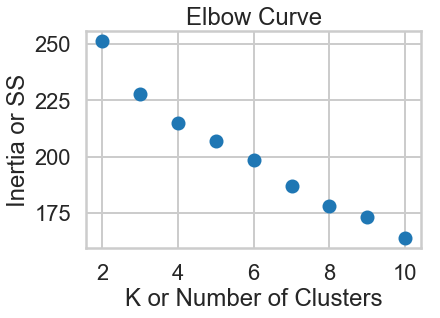

In [56]:
_ = plt.scatter(ks, ss)
_ = plt.ylabel('Inertia or SS')
_ = plt.xlabel('K or Number of Clusters')
_ = plt.title('Elbow Curve')

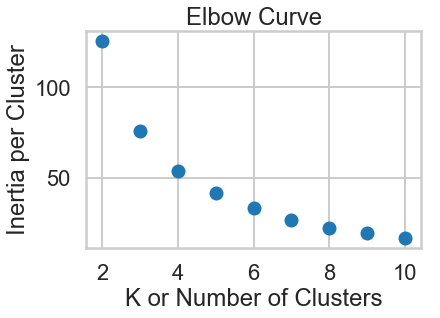

In [57]:
_ = plt.scatter(ks, ss_per_k)
_ = plt.ylabel('Inertia per Cluster')
_ = plt.xlabel('K or Number of Clusters')
_ = plt.title('Elbow Curve')

These graphs have a less elbow-y behavior than the other elbow graphs I have seen. I think K = 3 looks good.

In [58]:
best_kmean = KMeans(n_clusters=3, random_state=0)
best_kmean.fit(x_cols)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=0, tol=0.0001, verbose=0)

In [59]:
best_kmean.labels_

array([2, 0, 1, 2, 0, 0, 1, 2, 0, 2, 0, 1, 2, 0, 2, 1, 0, 1, 2, 0, 2, 2,
       0, 0, 1, 0, 0, 0, 0, 1, 2, 2, 0, 0, 2, 2, 0, 2, 0, 2, 1, 1, 2, 0,
       2, 0, 2, 2, 0, 0, 0, 0, 0, 1, 0, 2, 1, 2, 2, 0, 0, 2, 0, 2, 2, 1,
       1, 0, 0, 0, 0, 0, 0, 2, 0, 2, 1, 2, 2, 1, 0, 0, 0, 1, 2, 2, 2, 0,
       0, 2, 0, 2, 0, 2, 0, 0, 2, 0, 0, 0])

In [67]:
print(sum(label == 0 for label in best_kmean.labels_))

48


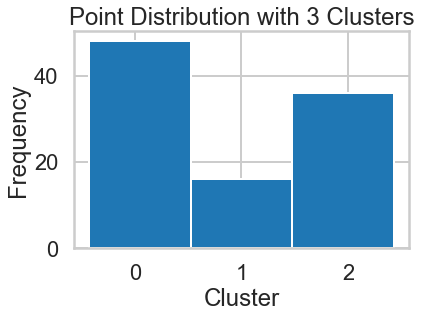

In [77]:
_ = plt.hist(best_kmean.labels_, bins=3)
_ = plt.ylabel("Frequency")
_ = plt.xlabel("Cluster")
_ = plt.title("Point Distribution with 3 Clusters")
_ = plt.xticks(np.arange(0.3, 1.8, step=0.7), (0, 1, 2))

### Choosing K: The Silhouette Method

There exists another method that measures how well each datapoint $x_i$ "fits" its assigned cluster *and also* how poorly it fits into other clusters. This is a different way of looking at the same objective. Denote $a_{x_i}$ as the *average* distance from $x_i$ to all other points within its own cluster $k$. The lower the value, the better. On the other hand $b_{x_i}$ is the minimum average distance from $x_i$ to points in a different cluster, minimized over clusters. That is, compute separately for each cluster the average distance from $x_i$ to the points within that cluster, and then take the minimum. The silhouette $s(x_i)$ is defined as

$$s(x_i) = \frac{b_{x_i} - a_{x_i}}{\max{\left( a_{x_i}, b_{x_i}\right)}}$$

The silhouette score is computed on *every datapoint in every cluster*. The silhouette score ranges from -1 (a poor clustering) to +1 (a very dense clustering) with 0 denoting the situation where clusters overlap. Some criteria for the silhouette coefficient is provided in the table below.

<pre>

| Range       | Interpretation                                |
|-------------|-----------------------------------------------|
| 0.71 - 1.0  | A strong structure has been found.            |
| 0.51 - 0.7  | A reasonable structure has been found.        |
| 0.26 - 0.5  | The structure is weak and could be artificial.|
| < 0.25      | No substantial structure has been found.      |

</pre>
Source: http://www.stat.berkeley.edu/~spector/s133/Clus.html

Fortunately, scikit-learn provides a function to compute this for us (phew!) called [`sklearn.metrics.silhouette_score`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html). Take a look at [this article](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html) on picking $K$ in scikit-learn, as it will help you in the next exercise set.

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set III</h3>

<p><b>Exercise:</b> Using the documentation for the `silhouette_score` function above, construct a series of silhouette plots like the ones in the article linked above.</p>

<p><b>Exercise:</b> Compute the average silhouette score for each $K$ and plot it. What $K$ does the plot suggest we should choose? Does it differ from what we found using the Elbow method?</p>
</div>

In [117]:
from sklearn.metrics import silhouette_score, silhouette_samples
import matplotlib.cm as cm

Silhouette Score for n = 2: 0.09174871508750351
Silhouette Score for n = 3: 0.12101628521627421
Silhouette Score for n = 4: 0.13421536289944658
Silhouette Score for n = 5: 0.11749792889789946
Silhouette Score for n = 6: 0.11001951281555851


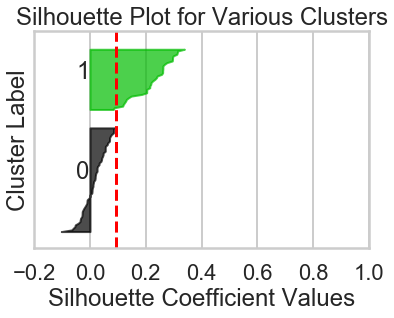

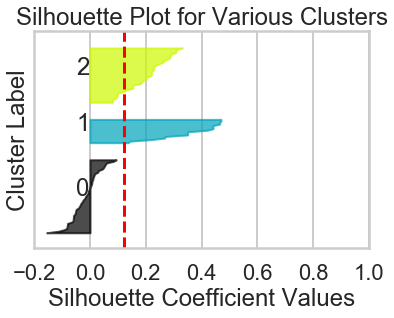

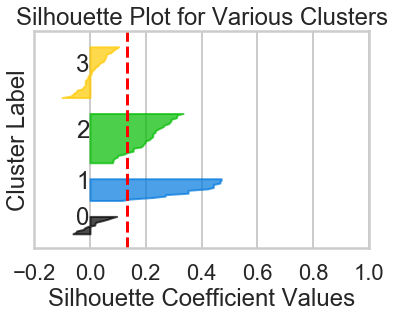

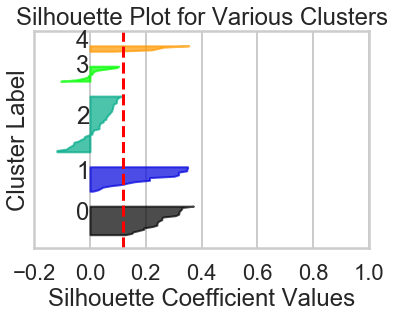

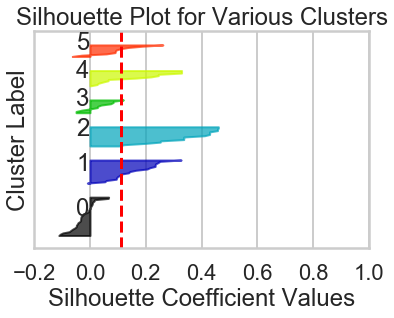

In [128]:
cluster_range = [2, 3, 4, 5, 6]

for n in cluster_range:
    # Make plot
    fig, ax = plt.subplots(1, 1)
    ax.set_xlim([-0.2, 1])
    ax.set_ylim([0, len(x_cols) + (n + 1) * 10])
    
    # Set up KMeans model and predictions
    model = KMeans(n_clusters=n, random_state=0)
    cluster_labels = model.fit_predict(x_cols)
    
    # Print avg silhouette score for n
    sil_score = silhouette_score(x_cols, cluster_labels)
    print("Silhouette Score for n = " + str(n) + ": " + str(sil_score))
    
    # Compute silhouette score for each sample
    sample_sil_vals = silhouette_samples(x_cols, cluster_labels)

    y_lower = 10
    
    # collect silhouette scores for each cluster, sort
    for i in range(n):
        # Get silhouette values for the ith cluster
        ith_cluster_sil_vals = sample_sil_vals[cluster_labels == i]
        ith_cluster_sil_vals.sort()
    
        # How many samples in the cluster?
        size_cluster_i = ith_cluster_sil_vals.shape[0]
    
        # Formatting for the figure
        y_upper = y_lower + size_cluster_i
    
        # Put bars on the graph
        color = cm.nipy_spectral(float(i) / n)
        ax.fill_betweenx(np.arange(y_lower, y_upper),
                    0, ith_cluster_sil_vals,
                    facecolor=color, edgecolor=color, alpha=0.7)
    
        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
    
        # Visible offset for the next cluster on the figure
        y_lower = y_upper + 10
        
    ax.set_title("Silhouette Plot for Various Clusters")
    ax.set_xlabel("Silhouette Coefficient Values")
    ax.set_ylabel("Cluster Label")

    ax.set_yticks([])
    ax.set_xticks([-0.2, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # Draw line for the average silhouette value
    ax.axvline(x=sil_score, color='red', linestyle='--')

This method suggests choosing 4 clusters, whereas the elbow method (roughly) suggested 3.

However, both models agree that this data is difficult to cluster. All of the average silhouette values are below 0.15. The table above this problem set indicates that a silhouette value of 0.15 means no substantial structure has been found.

### Choosing $K$: The Gap Statistic

There is one last method worth covering for picking $K$, the so-called Gap statistic. The computation for the gap statistic builds on the sum-of-squares established in the Elbow method discussion, and compares it to the sum-of-squares of a "null distribution," that is, a random set of points with no clustering. The estimate for the optimal number of clusters $K$ is the value for which $\log{SS}$ falls the farthest below that of the reference distribution:

$$G_k = E_n^*\{\log SS_k\} - \log SS_k$$

In other words a good clustering yields a much larger difference between the reference distribution and the clustered data. The reference distribution is a Monte Carlo (randomization) procedure that constructs $B$ random distributions of points within the bounding box (limits) of the original data and then applies K-means to this synthetic distribution of data points.. $E_n^*\{\log SS_k\}$ is just the average $SS_k$ over all $B$ replicates. We then compute the standard deviation $\sigma_{SS}$ of the values of $SS_k$ computed from the $B$ replicates of the reference distribution and compute

$$s_k = \sqrt{1+1/B}\sigma_{SS}$$

Finally, we choose $K=k$ such that $G_k \geq G_{k+1} - s_{k+1}$.

### Aside: Choosing $K$ when we Have Labels

Unsupervised learning expects that we do not have the labels. In some situations, we may wish to cluster data that is labeled. Computing the optimal number of clusters is much easier if we have access to labels. There are several methods available. We will not go into the math or details since it is rare to have access to the labels, but we provide the names and references of these measures.

* Adjusted Rand Index
* Mutual Information
* V-Measure
* Fowlkes–Mallows index

See [this article](http://scikit-learn.org/stable/modules/clustering.html) for more information about these metrics.

## Visualizing Clusters using PCA

How do we visualize clusters? If we only had two features, we could likely plot the data as is. But we have 100 data points each containing 32 features (dimensions). Principal Component Analysis (PCA) will help us reduce the dimensionality of our data from 32 to something lower. For a visualization on the coordinate plane, we will use 2 dimensions. In this exercise, we're going to use it to transform our multi-dimensional dataset into a 2 dimensional dataset.

This is only one use of PCA for dimension reduction. We can also use PCA when we want to perform regression but we have a set of highly correlated variables. PCA untangles these correlations into a smaller number of features/predictors all of which are orthogonal (not correlated). PCA is also used to reduce a large set of variables into a much smaller one.

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set IV</h3>

<p><b>Exercise:</b> Use PCA to plot your clusters:</p>

<ul>
<li> Use scikit-learn's [`PCA`](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) function to reduce the dimensionality of your clustering data to 2 components
<li> Create a data frame with the following fields:
  <ul>
  <li> customer name
  <li> cluster id the customer belongs to
  <li> the two PCA components (label them `x` and `y`)
  </ul>
<li> Plot a scatterplot of the `x` vs `y` columns
<li> Color-code points differently based on cluster ID
<li> How do the clusters look? 
<li> Based on what you see, what seems to be the best value for $K$? Moreover, which method of choosing $K$ seems to have produced the optimal result visually?
</ul>

<p><b>Exercise:</b> Now look at both the original raw data about the offers and transactions and look at the fitted clusters. Tell a story about the clusters in context of the original data. For example, do the clusters correspond to wine variants or something else interesting?</p>
</div>

In [129]:
from sklearn.decomposition import PCA

In [132]:
pca = PCA(n_components=2, random_state=0)
reduced_data = pca.fit_transform(x_cols)
reduced_data[0:5,:]

array([[ 1.00757996,  0.10821467],
       [-0.28753924,  0.04471451],
       [-0.39203204,  1.03839141],
       [ 0.69947727, -0.02254222],
       [ 0.08818322, -0.47169543]])

In [134]:
# Cluster with dimensionality-reduced data and predict
model = KMeans(n_clusters=4, random_state=0)
reduced_data_pred = model.fit_predict(reduced_data)
reduced_data_pred

array([0, 3, 2, 0, 3, 1, 2, 0, 1, 0, 1, 2, 0, 1, 3, 2, 3, 2, 0, 1, 0, 3,
       1, 1, 2, 1, 3, 3, 3, 2, 3, 3, 1, 1, 3, 0, 1, 0, 1, 0, 2, 2, 3, 1,
       0, 1, 0, 3, 1, 3, 3, 1, 3, 2, 1, 0, 2, 3, 0, 1, 3, 3, 3, 0, 0, 2,
       2, 3, 1, 3, 3, 3, 1, 0, 3, 0, 2, 3, 3, 2, 1, 1, 1, 2, 0, 0, 0, 1,
       3, 3, 1, 0, 3, 0, 3, 1, 0, 1, 1, 1])

In [135]:
# Create a new dataframe
pca_df = pd.DataFrame({'Customer': pivoted_df.index.values,
                       'Cluster ID': reduced_data_pred,
                       'x': reduced_data[:, 0],
                       'y': reduced_data[:, 1]})

Text(0.5,1,'PCA Data Visualization')

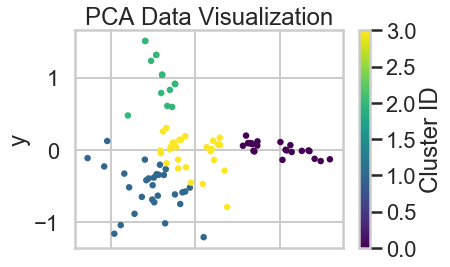

In [148]:
pca_df.plot.scatter('x', 'y', c='Cluster ID', colormap='viridis')
plt.title('PCA Data Visualization')

The clusters seem reasonable. There are two clusters (the ones that almost look like lines) that seem as outliers for the more central clusters (blue and yellow).

I understand why the elbow graph showed me a decent result for 3 clusters now.

Choosing 3 or 4 clusters both seem appropriate based on this visualization. The elbow graph could have suggested either, and the Silhouette method suggested 4, but 3 was the next best number.

In [152]:
pca_df.head()

,Cluster ID,Customer,x,y
0,0,Adams,1.007580,0.108215
1,3,Allen,-0.287539,0.044715
2,2,Anderson,-0.392032,1.038391
3,0,Bailey,0.699477,-0.022542
4,3,Baker,0.088183,-0.471695


In [224]:
# For each set of customers in a given Cluster ID
# Show the offer table, but all 1.0s are replaced with the offer's wine origin 
# Again, but replace 1.0s with other aspects of the offer
# Example code to repeat in the for loop below

cluster_df = pivoted_df.reset_index(drop=True)[pca_df['Cluster ID'] == 0]
cluster_df.columns = df_offers.origin.values
cluster_df.loc[:, (cluster_df != 0).any(axis=0)].head()

,Australia,South Africa,Chile,Oregon,France,France
0,0.0,0.0,0.0,1.0,1.0,1.0
3,1.0,0.0,0.0,0.0,0.0,1.0
7,0.0,1.0,0.0,0.0,1.0,0.0
9,1.0,0.0,0.0,0.0,1.0,1.0
12,1.0,0.0,1.0,0.0,1.0,1.0


In [237]:
df_offers.columns.values

array(['offer_id', 'campaign', 'varietal', 'min_qty', 'discount',
       'origin', 'past_peak'], dtype=object)

In [248]:
for cluster in pca_df['Cluster ID'].sort_values().unique():
    cluster_df = pivoted_df.reset_index(drop=True)[pca_df['Cluster ID'] == cluster]
    print("For cluster {}, there were {} customers".format(cluster, len(sub_df)))
    
    for col in df_offers.columns:
        sub_df = cluster_df
        sub_df.columns = df_offers[col].values
        sub_df = sub_df.loc[:, (sub_df != 0).any(axis=0)]
    
        print("{} total {}s: {}".format(len(sub_df.columns.unique()), col, sub_df.columns.sort_values().unique().values))
    
    print("\n")
    #cluster_df.columns = df_offers.origin.values
    
    #sub_df = cluster_df.loc[:, (cluster_df != 0).any(axis=0)]
    #print("For cluster {}, there were {} customers and {} unique offers accepted."
          #.format(cluster, len(sub_df), len(sub_df.columns)))
    
    
    #print("There were {} countries: {}\n".format(len(sub_df.columns.unique()),sub_df.columns.sort_values().unique()))

For cluster 0, there were 31 customers
6 total offer_ids: [ 7  8 13 18 29 30]
5 total campaigns: [u'December' u'July' u'March' u'May' u'November']
5 total varietals: [u'Espumante' u'Malbec' u'Merlot' u'Pinot Grigio' u'Prosecco']
1 total min_qtys: [6]
6 total discounts: [40 43 45 50 54 87]
5 total origins: [u'Australia' u'Chile' u'France' u'Oregon' u'South Africa']
2 total past_peaks: [False True]


For cluster 1, there were 24 customers
28 total offer_ids: [ 1  2  3  4  5  6  7  8  9 10 11 12 14 15 16 18 19 20 21 22 23 25 26 27
 28 30 31 32]
12 total campaigns: [u'April' u'August' u'December' u'February' u'January' u'July' u'June'
 u'March' u'May' u'November' u'October' u'September']
8 total varietals: [u'Cabernet Sauvignon' u'Champagne' u'Chardonnay' u'Espumante' u'Malbec'
 u'Merlot' u'Pinot Noir' u'Prosecco']
4 total min_qtys: [  6  12  72 144]
23 total discounts: [17 19 32 39 40 44 45 48 50 52 54 56 57 59 63 64 66 82 83 85 86 88 89]
9 total origins: [u'Australia' u'California' u'Chi

Cluster 0's customers had a narrow selection of wine and only a minimum quantity of 6.

Cluster 2's customers took offers that were past peak, and had a narrow selection of wine.

Clusters 1 and 3 were all over the place. They both had 28 offer ids, all 12 months of campaigns, 4 minimum quantities, over 20 total discounts, 9 wine origins, and 8-9 varietals.

Clusters 1 and 3 could well be narrowed down, if the model had access to all this information and not just the offer ids.

<div class="span5 alert alert-info">
<h3>Exercise Set V</h3>

<p>As we saw earlier, PCA has a lot of other uses. Since we wanted to visualize our data in 2 dimensions, restricted the number of dimensions to 2 in PCA. But what is the true optimal number of dimensions?</p>

<p><b>Exercise:</b> Using a new PCA object shown in the next cell, plot the `explained_variance_` field and look for the elbow point, the point where the curve's rate of descent seems to slow sharply. This value is one possible value for the optimal number of dimensions. What is it?</p>
</div>

[0.4096489  0.30753551 0.2022926  0.16703717 0.15015248 0.1434373
 0.13818887 0.12192294 0.11636172 0.10804271 0.09937813 0.09495961
 0.08690352 0.07256738 0.0660996  0.06245473 0.05634388 0.05327395
 0.04728801 0.04393911 0.03900424 0.03625783 0.03455714 0.03235091
 0.02940632 0.02618221 0.02308167 0.02142632 0.018814   0.0165252
 0.01426187 0.0077789 ]


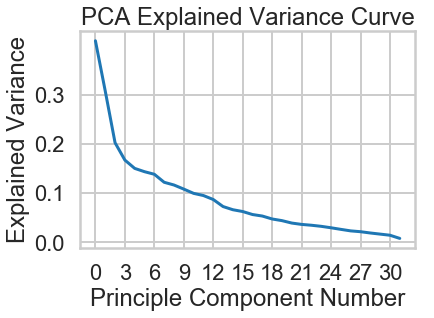

In [271]:
# Initialize a new PCA model with a default number of components.
import sklearn.decomposition
pca = sklearn.decomposition.PCA()
pca.fit(x_cols)
print(np.array(pca.explained_variance_))

# Do the rest on your own :)
_ = plt.plot(pca.explained_variance_)
_ = plt.ylabel('Explained Variance')
_ = plt.xlabel('Principle Component Number')
_ = plt.title('PCA Explained Variance Curve')
_ = plt.xticks(np.arange(0, 33, 3))
_ = plt.yticks(np.arange(0, 0.4, 0.1))

This plot indicates that we should probably represent this data in 3 principle components, since the 3rd component on the graph is where the rate of descent slows sharply.

## Other Clustering Algorithms

k-means is only one of a ton of clustering algorithms. Below is a brief description of several clustering algorithms, and the table provides references to the other clustering algorithms in scikit-learn. 

* **Affinity Propagation** does not require the number of clusters $K$ to be known in advance! AP uses a "message passing" paradigm to cluster points based on their similarity. 

* **Spectral Clustering** uses the eigenvalues of a similarity matrix to reduce the dimensionality of the data before clustering in a lower dimensional space. This is tangentially similar to what we did to visualize k-means clusters using PCA. The number of clusters must be known a priori.

* **Ward's Method** applies to hierarchical clustering. Hierarchical clustering algorithms take a set of data and successively divide the observations into more and more clusters at each layer of the hierarchy. Ward's method is used to determine when two clusters in the hierarchy should be combined into one. It is basically an extension of hierarchical clustering. Hierarchical clustering is *divisive*, that is, all observations are part of the same cluster at first, and at each successive iteration, the clusters are made smaller and smaller. With hierarchical clustering, a hierarchy is constructed, and there is not really the concept of "number of clusters." The number of clusters simply determines how low or how high in the hierarchy we reference and can be determined empirically or by looking at the [dendogram](https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.cluster.hierarchy.dendrogram.html).

* **Agglomerative Clustering** is similar to hierarchical clustering but but is not divisive, it is *agglomerative*. That is, every observation is placed into its own cluster and at each iteration or level or the hierarchy, observations are merged into fewer and fewer clusters until convergence. Similar to hierarchical clustering, the constructed hierarchy contains all possible numbers of clusters and it is up to the analyst to pick the number by reviewing statistics or the dendogram.

* **DBSCAN** is based on point density rather than distance. It groups together points with many nearby neighbors. DBSCAN is one of the most cited algorithms in the literature. It does not require knowing the number of clusters a priori, but does require specifying the neighborhood size.

### Clustering Algorithms in Scikit-learn
<table border="1">
<colgroup>
<col width="15%" />
<col width="16%" />
<col width="20%" />
<col width="27%" />
<col width="22%" />
</colgroup>
<thead valign="bottom">
<tr><th>Method name</th>
<th>Parameters</th>
<th>Scalability</th>
<th>Use Case</th>
<th>Geometry (metric used)</th>
</tr>
</thead>
<tbody valign="top">
<tr><td>K-Means</span></a></td>
<td>number of clusters</td>
<td>Very large<span class="pre">n_samples</span>, medium <span class="pre">n_clusters</span> with
MiniBatch code</td>
<td>General-purpose, even cluster size, flat geometry, not too many clusters</td>
<td>Distances between points</td>
</tr>
<tr><td>Affinity propagation</td>
<td>damping, sample preference</td>
<td>Not scalable with n_samples</td>
<td>Many clusters, uneven cluster size, non-flat geometry</td>
<td>Graph distance (e.g. nearest-neighbor graph)</td>
</tr>
<tr><td>Mean-shift</td>
<td>bandwidth</td>
<td>Not scalable with <span class="pre">n_samples</span></td>
<td>Many clusters, uneven cluster size, non-flat geometry</td>
<td>Distances between points</td>
</tr>
<tr><td>Spectral clustering</td>
<td>number of clusters</td>
<td>Medium <span class="pre">n_samples</span>, small <span class="pre">n_clusters</span></td>
<td>Few clusters, even cluster size, non-flat geometry</td>
<td>Graph distance (e.g. nearest-neighbor graph)</td>
</tr>
<tr><td>Ward hierarchical clustering</td>
<td>number of clusters</td>
<td>Large <span class="pre">n_samples</span> and <span class="pre">n_clusters</span></td>
<td>Many clusters, possibly connectivity constraints</td>
<td>Distances between points</td>
</tr>
<tr><td>Agglomerative clustering</td>
<td>number of clusters, linkage type, distance</td>
<td>Large <span class="pre">n_samples</span> and <span class="pre">n_clusters</span></td>
<td>Many clusters, possibly connectivity constraints, non Euclidean
distances</td>
<td>Any pairwise distance</td>
</tr>
<tr><td>DBSCAN</td>
<td>neighborhood size</td>
<td>Very large <span class="pre">n_samples</span>, medium <span class="pre">n_clusters</span></td>
<td>Non-flat geometry, uneven cluster sizes</td>
<td>Distances between nearest points</td>
</tr>
<tr><td>Gaussian mixtures</td>
<td>many</td>
<td>Not scalable</td>
<td>Flat geometry, good for density estimation</td>
<td>Mahalanobis distances to  centers</td>
</tr>
<tr><td>Birch</td>
<td>branching factor, threshold, optional global clusterer.</td>
<td>Large <span class="pre">n_clusters</span> and <span class="pre">n_samples</span></td>
<td>Large dataset, outlier removal, data reduction.</td>
<td>Euclidean distance between points</td>
</tr>
</tbody>
</table>
Source: http://scikit-learn.org/stable/modules/clustering.html

<div class="span5 alert alert-info">
<h3>Exercise Set VI</h3>

<p><b>Exercise:</b> Try clustering using the following algorithms. </p>
<ol>
<li>Affinity propagation
<li>Spectral clustering
<li>Agglomerative clustering
<li>DBSCAN
</ol>
<p>How do their results compare? Which performs the best? Tell a story why you think it performs the best.</p>
</div>


In [273]:
from sklearn.cluster import AffinityPropagation, SpectralClustering, AgglomerativeClustering, DBSCAN

In [293]:
model = AffinityPropagation()
model.fit(x_cols)
AP_labels = model.predict(x_cols)
print("Affinity Propagation predicts {} clusters".format(np.max(model.labels_)+1))

Affinity Propagation predicts 14 clusters


In [294]:
AP_consistent = model.labels_ == AP_labels
AP_consistent

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True, False,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True, False,  True,  True,  True,  True,
       False,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True, False,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
       False,  True, False,  True,  True,  True,  True,  True,  True,
       False])

Affinity Propagation predicts 14 clusters, which disagrees with the previous analyses, and doesn't even predict labels quite consistently for the given data. This algorithm might struggle with this data without hyperparameter tuning.

In [299]:
model = SpectralClustering(n_clusters=4)
SC_labels = model.fit_predict(x_cols)
SC_labels

array([1, 0, 2, 1, 0, 0, 2, 3, 0, 1, 0, 2, 1, 0, 1, 2, 0, 2, 1, 0, 1, 3,
       0, 0, 2, 0, 0, 0, 0, 2, 1, 3, 0, 0, 1, 3, 0, 1, 0, 1, 2, 2, 3, 0,
       1, 0, 1, 1, 0, 0, 0, 0, 0, 2, 0, 3, 2, 1, 1, 3, 0, 3, 0, 1, 1, 2,
       2, 0, 0, 0, 0, 0, 0, 1, 0, 1, 2, 0, 1, 2, 0, 0, 0, 2, 3, 3, 1, 0,
       0, 3, 0, 1, 0, 1, 0, 0, 3, 0, 0, 0])

Spectral Clustering can't fit and predict separately, so it's predictions match the labels on the training data. It also might perform better since I gave it the optimal number of clusters from the previous analyses.

In [298]:
model = AgglomerativeClustering(n_clusters=4)
AC_labels = model.fit_predict(x_cols)
AC_labels

array([1, 0, 2, 1, 0, 0, 2, 1, 0, 1, 0, 2, 1, 0, 1, 2, 0, 2, 1, 0, 1, 1,
       3, 0, 2, 0, 0, 0, 0, 2, 1, 1, 0, 3, 1, 1, 0, 1, 0, 1, 2, 2, 1, 0,
       1, 3, 1, 0, 0, 0, 0, 0, 2, 2, 3, 1, 2, 1, 1, 0, 0, 1, 0, 1, 1, 2,
       2, 0, 0, 0, 0, 0, 3, 1, 0, 1, 2, 3, 1, 2, 0, 0, 0, 2, 1, 1, 1, 0,
       0, 1, 3, 1, 0, 1, 0, 0, 1, 0, 3, 0], dtype=int64)

In [303]:
model = DBSCAN(0.5)
DB_labels = model.fit_predict(x_cols)
DB_labels

array([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
      dtype=int64)

DBSCAN doesn't appear to work here.

In [306]:
# Put the predictions into the PCA dataframe, and see if they are consistent
pca_df['AP_id'] = AP_labels
pca_df['SC_id'] = SC_labels
pca_df['AC_id'] = AC_labels

Text(0.5,1,'KMeans Clustering in PCA Space')

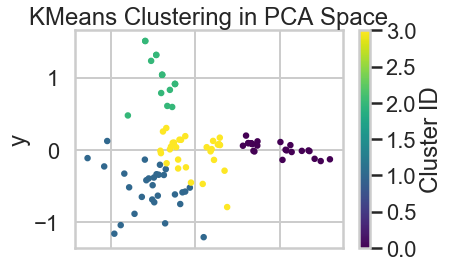

In [308]:
# Compare how each method clusters based on the 2d space we got from PCA
# Here is the original plot from PCA and KMeans
pca_df.plot.scatter('x', 'y', c='Cluster ID', colormap='viridis')
plt.title('KMeans Clustering in PCA Space')

Text(0.5,1,'Affinity Propagation in PCA Space')

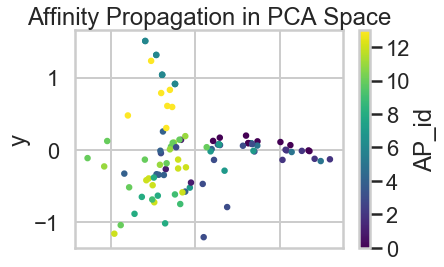

In [309]:
pca_df.plot.scatter('x', 'y', c='AP_id', colormap='viridis')
plt.title('Affinity Propagation in PCA Space')

Text(0.5,1,'Spectral Clustering in PCA Space')

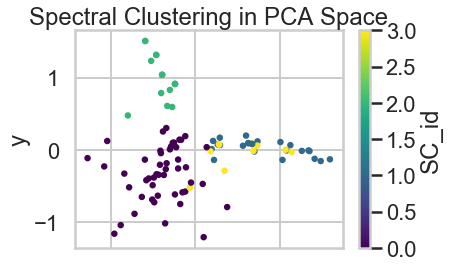

In [310]:
pca_df.plot.scatter('x', 'y', c='SC_id', colormap='viridis')
plt.title('Spectral Clustering in PCA Space')

Text(0.5,1,'Agglomerative Clustering in PCA Space')

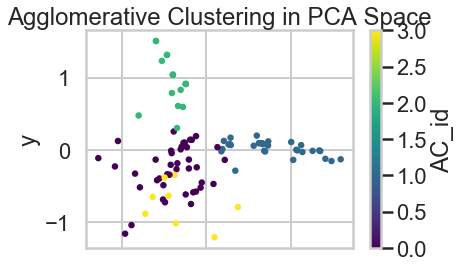

In [311]:
pca_df.plot.scatter('x', 'y', c='AC_id', colormap='viridis')
plt.title('Agglomerative Clustering in PCA Space')

Spectral and Agglomerative Clustering seemed to figure out the tails that 2-dimensional PCA found.

Spectral Clustering opted to make most of the center 1 cluster and split the right tail into 2 clusters, which doesn't make sense in this PCA space (but this PCA space doesn't really mean anything).

Agglomerative Clustering found both of the tails from my PCA, and just split the main bunch of points into a different set than PCA did. I think Agglomerative Clustering did the best.

Affinity Propagation's 14 clusters is mostly nonsense, so I don't think that performed very well.